In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from scipy.linalg import sqrtm

2022-09-28 22:35:27.847786: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.transform import resize
import numpy as np
import time
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'

In [ ]:
import tensorflow.keras.applications.inception_v3 as pretrained_models
preprocess = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [3]:
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    info = tf.config.experimental.get_memory_info('GPU:0')
print(info)

{'current': 0, 'peak': 0}


2022-09-28 22:35:35.442212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 22:35:36.136361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46711 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [4]:
imgs_names = []
folder = "bitmojis/"
ln = 0
for filename in os.listdir(folder):
        imgs_names.append(filename)
        ln += 1
        

In [5]:
tot_imgs = []
for name in imgs_names:
    cur = image.imread(folder+name)
    tot_imgs.append(cur)


In [6]:
tot_imgs = np.array(tot_imgs)
print(tot_imgs.shape,tot_imgs.dtype)
tot_imgs = (tot_imgs-0.5)*2

(130227, 128, 128, 3) float32


In [8]:
noise_dim = 100
BATCH_SIZE = 256


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6553600   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107200  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

2022-09-28 22:36:39.968718: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-28 22:36:40.374177: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


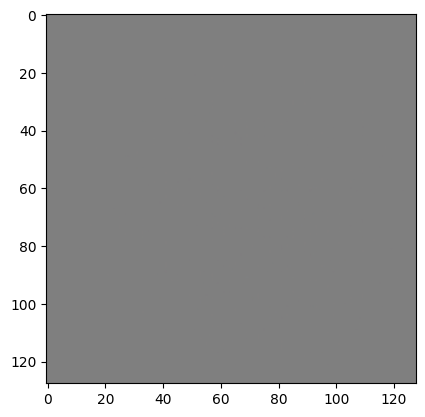

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256*4,use_bias = False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 1024)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    tf.keras.layers.Dropout(0.3)

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False ))
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    tf.keras.layers.Dropout(0.3)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    tf.keras.layers.Dropout(0.3)
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = "tanh" ))
    
    
    return model

generator = make_generator_model()
print(generator.summary())
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :]+1)/2)

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[128,128, 3]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00020216]], shape=(1, 1), dtype=float32)


In [11]:

def discriminator_loss(real_output, fake_output):
    
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    
    return -tf.reduce_mean(fake_output)

generator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [17]:

def train_step(images):
    for i in range(5):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images,training=True)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        capped_disc_grads = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients_of_discriminator]
        discriminator_optimizer.apply_gradients(zip(capped_disc_grads, discriminator.trainable_variables))
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    capped_gen_grads = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients_of_generator]
    generator_optimizer.apply_gradients(zip(capped_gen_grads, generator.trainable_variables))
    
    return gen_loss,disc_loss

In [13]:
def train(dataset, epochs):
    batches = dataset.shape[0]//BATCH_SIZE
    
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        print("start")
        start = time.time()
        cur = 0
        tot_gen_ls = 0
        tot_disc_ls = 0
        for x in range(batches):
            gen_ls,disc_ls = train_step(dataset[cur:cur+BATCH_SIZE])
            tot_gen_ls += gen_ls
            tot_disc_ls += disc_ls
            cur += BATCH_SIZE
        
        gen_losses.append(tot_gen_ls/batches)
        disc_losses.append(tot_disc_ls/batches)
    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(gen_losses[-1],disc_losses[-1])
    return gen_losses,disc_losses


In [18]:
# for i in range(1):
gen_losses,disc_losses = train(tot_imgs, 20)
#     train(train_dataset2, 1)

start
Time for epoch 1 is 768.4407770633698 sec
tf.Tensor(-88211790.0, shape=(), dtype=float32) tf.Tensor(-2379780.0, shape=(), dtype=float32)
start
Time for epoch 2 is 769.8914918899536 sec
tf.Tensor(-9513505.0, shape=(), dtype=float32) tf.Tensor(-565894.5, shape=(), dtype=float32)
start
Time for epoch 3 is 769.3671462535858 sec
tf.Tensor(-73511290.0, shape=(), dtype=float32) tf.Tensor(-3787279.0, shape=(), dtype=float32)
start
Time for epoch 4 is 768.7646064758301 sec
tf.Tensor(-226439400.0, shape=(), dtype=float32) tf.Tensor(-12534735.0, shape=(), dtype=float32)
start
Time for epoch 5 is 769.1111099720001 sec
tf.Tensor(-494928500.0, shape=(), dtype=float32) tf.Tensor(-13093632.0, shape=(), dtype=float32)
start
Time for epoch 6 is 768.9160511493683 sec
tf.Tensor(-1090935200.0, shape=(), dtype=float32) tf.Tensor(-67955410.0, shape=(), dtype=float32)
start
Time for epoch 7 is 768.7933640480042 sec
tf.Tensor(-3083991000.0, shape=(), dtype=float32) tf.Tensor(-104051950.0, shape=(), dtype

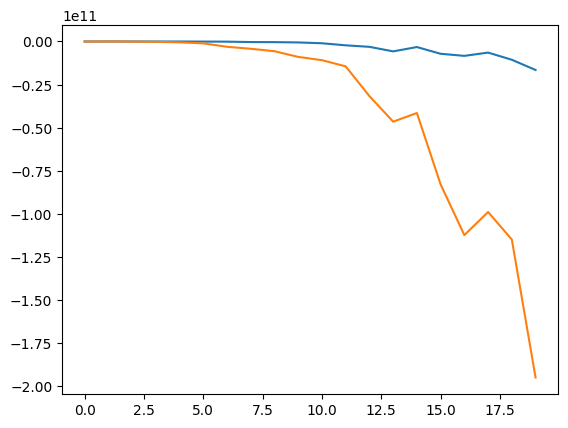

In [22]:
plt.plot(disc_losses)
plt.plot(gen_losses)

In [19]:
def image_generate(n):
    noise = tf.random.normal(shape = (n*n,100))
    dt = generator(noise,training = False)
    imgs = (dt+1)/2
    fig,ax = plt.subplots(n,n)
    cur = 0
    if(n==1):
        ax.imshow(imgs[0])
        return
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(imgs[cur])
            ax[i,j].axis('off')
            cur += 1

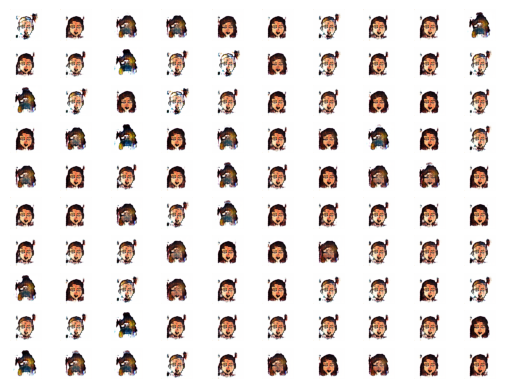

In [25]:
image_generate(10)

In [21]:
generator.save("wgan_generator")
discriminator.save("wgan_discriminator")

INFO:tensorflow:Assets written to: wgan_generator/assets


INFO:tensorflow:Assets written to: wgan_generator/assets


INFO:tensorflow:Assets written to: wgan_discriminator/assets


INFO:tensorflow:Assets written to: wgan_discriminator/assets


In [23]:
inception = pretrained_models.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

NameError: name 'pretrained_models' is not defined

In [ ]:
def scale_for_incept(imgs):
    tot = []
    for img in imgs:
        tot.append(resize(img,(299,299,3)))
        
    return np.array(tot)

In [ ]:
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    print("generated_features done")
    act2 = model.predict(images2)
# calculate mean and covariance statistics
    print("calculating")
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # clculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
def overall_fids(model):
    all_fids = []
    for i in range(20):
        noise = tf.random.normal(shape = (1000,noise_dim))
        generated_imgs = generator(noise,training = False)
        real_indices = random.sample(range(120000),1000)
        real_imgs = []
        for x in real_indices:
            real_imgs.append(tot_imgs[x])
        rl = (np.array(real_imgs)+1)/2
        gn = (generated_imgs+1)/2
        generated_imgs = scale_for_incept(rl)
        real_imgs = scale_for_incept(gn)
        gener_preproce = preprocess(generated_imgs)
        real_preproce = preprocess(real_imgs)
        cur_fid = calculate_fid(inception,generated_imgs,real_imgs)
        all_fids .append(cur_fid)
            
    return all_fids

In [ ]:
all_fids = overall_fids(inception)

In [ ]:
all_fids